In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
# df = df.drop(['Unnamed: 4'], axis=1)
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# spam -> 1, ham -> 0
df['b_labels'] = df['labels'].map({'spam':1, 'ham':0})
Y = df['b_labels'].values
Y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [7]:
df.describe()

,b_labels
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.33)

In [21]:
# tokenize -> word vector -> integer mapping => model
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [22]:
word2vec = tokenizer.word_index
V = len(word2vec)

In [23]:
print("Total {} unique tokens:".format(V))

Total 7313 unique tokens:


In [24]:
#padding(pre, post?) with pad_sequences()
data_train = pad_sequences(sequences_train)
print("sequences_train.shape: ", data_train.shape) # padding 줄 때 명칭이 바뀌었음

sequences_train.shape:  (3733, 115)


In [25]:
T = data_train.shape[1] # 길이값
T

115

In [28]:
data_test = pad_sequences(sequences_test, maxlen=T)
print("sequences_test.shape: ", data_test.shape)

sequences_test.shape:  (1839, 115)


In [34]:
# create model
# input -> lstm -> dense(sigmoid)
D = 20
M = 15 # Hidden state(Node)
# N(sample의 개수) T(시퀀스 개수) D(feature 개수)

i = Input(shape=(T,))
x = Embedding(V+1, D)(i) # 0 -> 1  # D : 벡터의 정보
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(1, activation='sigmoid')(x)

model= Model(i, x)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 115)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 115, 20)           146280    
_________________________________________________________________
lstm_5 (LSTM)                (None, 115, 15)           2160      
_________________________________________________________________
global_max_pooling1d (Global (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 148,456
Trainable params: 148,456
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
r = model.fit(data_train, Y_train, epochs=10, validation_data=(data_test, Y_test))

# padding 줄 때 X_train, X_test의 명칭이 바뀌었음

Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0091 - acc: 0.9992 - val_loss: 0.1084 - val_acc: 0.9744
Epoch 2/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0072 - acc: 0.9992 - val_loss: 0.0612 - val_acc: 0.9886
Epoch 3/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0059 - acc: 0.9995 - val_loss: 0.0560 - val_acc: 0.9897
Epoch 4/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0054 - acc: 0.9995 - val_loss: 0.0583 - val_acc: 0.9880
Epoch 5/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0045 - acc: 0.9995 - val_loss: 0.0573 - val_acc: 0.9891
Epoch 6/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0034 - acc: 0.9997 - val_loss: 0.0588 - val_acc: 0.9891
Epoch 7/10
3733/3733 [==============================] - 9s 2ms/sample - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0601 - val_acc: 0.9891


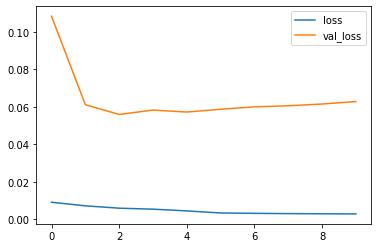

In [41]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

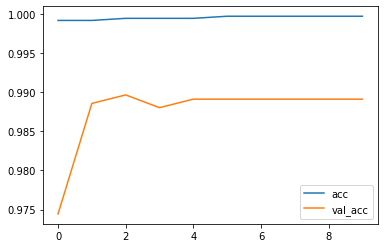

In [42]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [43]:
temp_i = Input(shape=(5,))
temp_x = Embedding(5,2)(temp_i) # 하나의 데이터 표현하는데에 2차수로 표현하겠다
temp_model = Model(temp_i, temp_x)


In [45]:
input_array = np.random.randint(5, size=(1,5))
input_array

array([[4, 1, 1, 4, 4]])

In [46]:
temp_model.compile(loss='mse', optimizer='adam')

In [47]:
output_array = temp_model.predict(input_array)
output_array

array([[[-0.03503419, -0.00695562],
        [-0.03318024,  0.00979133],
        [-0.03318024,  0.00979133],
        [-0.03503419, -0.00695562],
        [-0.03503419, -0.00695562]]], dtype=float32)